# Imports

In [1]:
import json
import textwrap

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly import io as pio

from sentence_transformers import SentenceTransformer

from sklearn.cluster import KMeans, DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import nltk
from nltk.corpus import stopwords

from tqdm import tqdm

tqdm.pandas()
nltk.download("stopwords")
nltk.download("punkt_tab")
nltk.download("omw-1.4")
nltk.download("wordnet")

/Users/alexbuyan/miniconda3/envs/fipi-parsing/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexbuyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/alexbuyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/alexbuyan/nltk_data...
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alexbuyan/nltk_data...


True

# Data

In [2]:
with open("../data/raw/tasks.json", "r") as file:
    data = json.load(file)

data = pd.DataFrame.from_dict(data, orient="columns")
data.head()

,id,guid,task_info,content,answer,answer_type,tags
0,q7DBD44,030477359D8083EF4F33120D8C7B88D5,i7DBD44,"Укажите варианты ответов, в которых в обоих сл...",,Выбор ответов из предложенных вариантов,[3.7.5 Правописание суффиксов]
1,q76BD40,0324D7A39FFB88D24945DE2B468D9A0F,i76BD40,"Определите ряд, в котором в обоих словах пропу...",,Краткий ответ,[3.7.3 Употребление ъ и ь (в том числе раздели...
2,q76164B,0345DDB9DCD884554F38CA7C2A583AA7,i76164B,В одном из приведённых ниже предложений НЕВЕРН...,,Краткий ответ,[3.3.3 Основные лексические нормы современного...
3,q7B1D45,038547F8734D9BA54067B2A64262F877,i7B1D45,Расставьте знаки препинания. Укажите предложен...,,Выбор ответов из предложенных вариантов,[3.8.4 Знаки препинания в предложениях с однор...
4,q738248,03FFE67AA360879B42D3DE3622F8B3CE,i738248,В одном из приведённых ниже слов допущена ошиб...,,Краткий ответ,[3.2.3 Основные нормы современного литературно...


In [3]:
data["options"] = data["content"].progress_apply(
    lambda x: " ".join(x.split("\n")[2:]).lower()
)
data["task"] = data["content"].progress_apply(
    lambda x: " ".join(x.split("\n")[:2]).lower()
)
data[["task", "options"]].head()

100%|██████████| 1220/1220 [00:00<00:00, 513038.99it/s]


,task,options
0,"укажите варианты ответов, в которых в обоих сл...","изменч..вость, варень..це выносл..вый, рассмат..."
1,"определите ряд, в котором в обоих словах пропу...","по..черкнуть, о..бой пр..смирел, пр..умный об...."
2,в одном из приведённых ниже предложений неверн...,у идеального правосудия три ключевых признака:...
3,расставьте знаки препинания. укажите предложен...,слышны были мерное дыхание спящих да треск гор...
4,в одном из приведённых ниже слов допущена ошиб...,озлобить вероисповедание ободрена закупорить


# Model

In [4]:
model = SentenceTransformer("sergeyzh/rubert-tiny-turbo")
# model = SentenceTransformer("cointegrated/rubert-tiny2")

# Clusters

## Embeddings

In [5]:
data["etask"] = data["task"].progress_apply(model.encode)
data["eoptions"] = data["options"].progress_apply(model.encode)

100%|██████████| 1220/1220 [00:14<00:00, 84.25it/s] 


In [6]:
etask = data["etask"].to_numpy()
data["etask"] = data["etask"].apply(np.reshape, args=((1, -1),))
etask = np.vstack(etask)

eoptions = data["eoptions"].to_numpy()
data["eoptions"] = data["eoptions"].apply(np.reshape, args=((1, -1),))
eoptions = np.vstack(eoptions)
print(etask.shape, eoptions.shape)

(1220, 312) (1220, 312)


## PCA

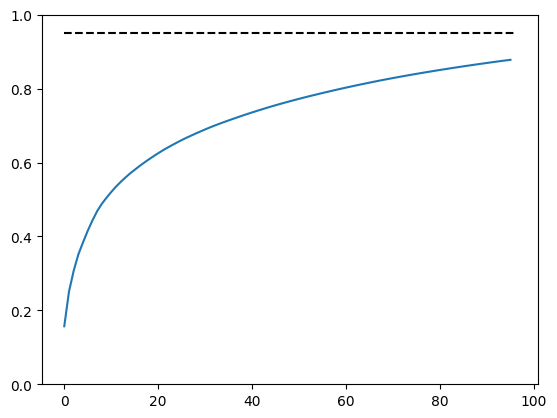

In [7]:
n_comp = 96
pca = PCA(n_components=n_comp)

pca.fit(etask)


plt.plot(np.arange(n_comp), pca.explained_variance_ratio_.cumsum())
plt.plot([0, n_comp], [0.95, 0.95], linestyle="dashed", c="black")
plt.ylim(0, 1)
plt.show()

In [8]:
pca = PCA(n_components=64)
etask = pca.fit_transform(etask)

data["etask"] = data["etask"].progress_apply(pca.transform)

100%|██████████| 1220/1220 [00:00<00:00, 24641.96it/s]


## KMeans

### Number of clusters

  0%|          | 0/31 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 31/31 [00:00<00:00, 39.50it/s]


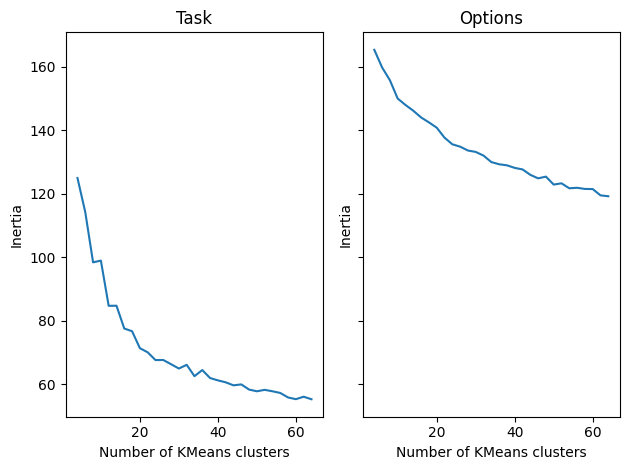

In [9]:
task_ssr = {}

for n_clusters in tqdm(range(4, 65, 2)):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(etask)
    task_ssr[n_clusters] = kmeans.inertia_

option_ssr = {}

for n_clusters in tqdm(range(4, 65, 2)):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(eoptions)
    option_ssr[n_clusters] = kmeans.inertia_

fig, ax = plt.subplots(1, 2, layout="tight", sharey=True)
ax[0].plot(task_ssr.keys(), task_ssr.values())
ax[1].plot(option_ssr.keys(), option_ssr.values())

ax[0].set_title("Task")
ax[1].set_title("Options")
ax[0].set_xlabel("Number of KMeans clusters")
ax[1].set_xlabel("Number of KMeans clusters")
ax[0].set_ylabel("Inertia")
ax[1].set_ylabel("Inertia")

plt.show()

### Fit KMeans

In [100]:
# Количество уникальных тегов из ноутбука alexbuyan-tags.ipynb
N_CLUSTERS = 6 # low-level - 28, high-level - 6
kmeans = KMeans(n_clusters=N_CLUSTERS)
kmeans.fit(etask)

KMeans(n_clusters=6)

In [101]:
data["cluster"] = data["etask"].progress_apply(kmeans.predict)
data["cluster"] = data["cluster"].apply(lambda x: x[0])

100%|██████████| 1220/1220 [00:00<00:00, 19182.66it/s]


### TFIDF

In [102]:
vectorizer = TfidfVectorizer(
    stop_words=stopwords.words("russian"), max_features=1000, ngram_range=(1, 2)
)

# Fit and transform the texts
tfidf_matrix = vectorizer.fit_transform(data["task"])

# Get the feature names (words)
feature_names = vectorizer.get_feature_names_out()
print(feature_names.shape)

(1000,)


In [103]:
def get_top_words(cluster_labels, tfidf_matrix, feature_names, num_top_words=8):
    top_words = {}
    for cluster in np.unique(cluster_labels):
        # Get the indices of texts in the current cluster
        if isinstance(cluster, np.ndarray):
            cluster = cluster[0]
        cluster_indices = np.where(cluster_labels == cluster)[0]

        # Get the TF-IDF matrix for the current cluster
        cluster_tfidf = tfidf_matrix[cluster_indices]

        # Sum the TF-IDF scores for each word in the cluster
        cluster_tfidf_sum = np.sum(cluster_tfidf, axis=0).A1

        # Get the indices of the top words
        top_word_indices = np.argsort(cluster_tfidf_sum)[-num_top_words:]

        # Get the top words
        top_words[cluster] = [feature_names[i] for i in top_word_indices]

    return top_words


# Get top words for each cluster
top_words = get_top_words(data["cluster"], tfidf_matrix, feature_names)

# Print top words for each cluster
for cluster, words in top_words.items():
    print(f"Cluster {cluster}: {words}")

Cluster 0: ['определите предложение', 'скобки выпишите', 'раскройте скобки', 'предложение котором', 'раскройте', 'слитно раскройте', 'скобки', 'слитно']
Cluster 1: ['месте которых', 'цифры месте', 'укажите цифры', 'цифры', 'пишется', 'пишется нн', 'нн', 'которых пишется']
Cluster 2: ['приведённых ниже', 'приведённых', 'неверно', 'исправьте', 'ошибку', 'одном', 'ниже', 'слово']
Cluster 3: ['одного ряда', 'словах одного', 'номера ответов', 'укажите варианты', 'варианты', 'варианты ответов', 'ответов которых', 'ответов']
Cluster 4: ['месте', 'стоять', 'расставьте знаки', 'препинания', 'препинания укажите', 'знаки препинания', 'расставьте', 'знаки']
Cluster 5: ['соответствие', 'соответствие грамматическими', 'соответствующую', 'позиции', 'позиции первого', 'позицию', 'соответствующую позицию', 'столбца']


## DBSCAN

### Fit DBSCAN

In [181]:
dbscan = DBSCAN(metric="cosine", eps=0.43)

dbscan.fit(etask)
print(f"Idetified {len(np.unique(dbscan.labels_))} labels")

Idetified 7 labels


In [182]:
data["dbscan_labels"] = dbscan.labels_

### TF-IDF

In [183]:
top_words = get_top_words(data["dbscan_labels"], tfidf_matrix, feature_names)

# Print top words for each cluster
for cluster, words in top_words.items():
    print(f"Cluster {cluster}: {words}")

Cluster -1: ['пишется нн', 'которых пишется', 'укажите', 'которых', 'ый', 'которых выделенным', 'ответов', 'пишется']
Cluster 0: ['ряда', 'одного ряда', 'словах', 'варианты', 'ответов которых', 'варианты ответов', 'укажите варианты', 'ответов']
Cluster 1: ['расставьте знаки', 'месте', 'препинания укажите', 'знаки препинания', 'расставьте', 'препинания', 'знаки', 'слово']
Cluster 2: ['соответствие', 'соответствие грамматическими', 'соответствующую', 'позиции', 'позиции первого', 'позицию', 'соответствующую позицию', 'столбца']
Cluster 3: ['пишется', 'слово котором', 'котором месте', 'месте пропуска', 'пропуска пишется', 'пропуска', 'пишется буква', 'выпишите слово']
Cluster 4: ['вставив', 'пропущенную', 'пропущенную букву', 'букву', 'определите слово', 'корня выпишите', 'слово вставив', 'котором пропущена']
Cluster 5: ['укажите цифры', 'цифры', 'цифры месте', 'месте которых', 'пишется', 'которых пишется', 'нн', 'пишется нн']


## Compare

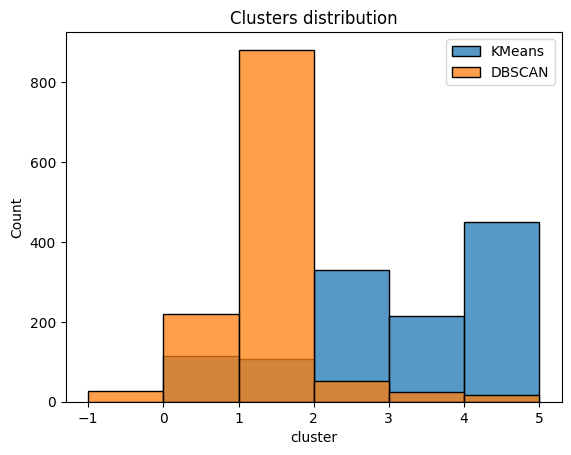

In [184]:
sns.histplot(data, x="cluster", label="KMeans", binwidth=1)
sns.histplot(data, x="dbscan_labels", label="DBSCAN", binwidth=1)
plt.title("Clusters distribution")
plt.legend()
plt.show()

## TSNE

In [185]:
tsne = TSNE()

etask2d = tsne.fit_transform(etask)

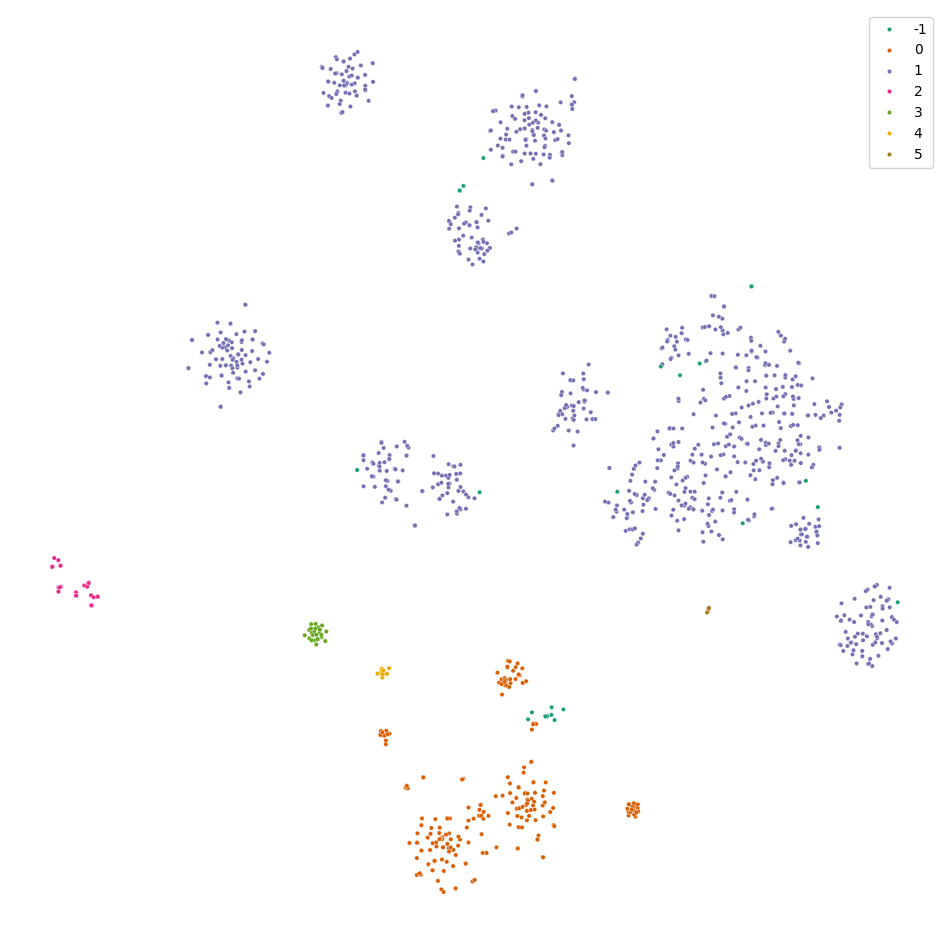

In [186]:
fig, ax = plt.subplots(figsize=(12, 12))

sns.scatterplot(
    x=etask2d[:, 0],
    y=etask2d[:, 1],
    s=10,
    hue=data["dbscan_labels"],
    palette="Dark2",
)

ax.set_frame_on(False)
plt.axis("off")
plt.legend()
plt.show()

### Interactive plot

In [187]:
def wrap_text(text, max_length=50):
    # Replace \n with <br>
    text = text.replace("\n", "<br>")
    # Wrap text at word boundaries
    wrapped_lines = textwrap.wrap(text, width=max_length)
    return "<br>".join(wrapped_lines)


default_colorscale = px.colors.cyclical.IceFire_r
colors = px.colors.sample_colorscale(
    default_colorscale, len(data["dbscan_labels"].unique())
)
colors = {i: color for i, color in zip(data["dbscan_labels"].unique(), colors)}


# Function to create the interactive plot
def create_interactive_plot(data, embeddings_2d, labels, most_common_words):
    unique_labels = np.unique(labels)
    fig = go.Figure()
    fig.update_layout(width=1000, height=1000)

    # Add cluster centroids
    for label in unique_labels:
        cluster_points = embeddings_2d[labels == label]
        centroid = np.mean(cluster_points, axis=0)

        fig.add_trace(
            go.Scatter(
                x=[centroid[0]],
                y=[centroid[1]],
                mode="markers+text",
                text=f"C{label}",
                textposition="top center",
                marker=dict(size=10, color=colors[label], opacity=1),
                textfont=dict(color=colors[label]),
                name=f"C{label}",
            )
        )

        # Add cluster points (initially hidden)
        fig.add_trace(
            go.Scatter(
                x=cluster_points[:, 0],
                y=cluster_points[:, 1],
                mode="markers",
                hovertext=data[labels == label]["content"].apply(wrap_text).tolist(),
                marker=dict(
                    size=5,
                    color=colors[label],
                    opacity=0.2,
                    line=(dict(width=2, color="DarkSlateGrey") if label < 0 else None),
                ),
                name=f"C{label} Points",
                visible=True,  # Initially hidden
                # legend=False,
            )
        )

        # Add most common words (initially hidden)
        words = most_common_words.get(label, [])
        off_xs, off_ys = [], []

        for i, word in enumerate(words):
            angle = 2 * np.pi * i / len(words)
            offset_x = 10 * np.cos(angle)
            offset_y = 10 * np.sin(angle)
            off_xs.append(offset_x)
            off_ys.append(offset_y)

        fig.add_trace(
            go.Scatter(
                x=[centroid[0] + offset_x for offset_x in off_xs],
                y=[centroid[1] + offset_y for offset_y in off_ys],
                mode="text",
                text=words,
                textposition="middle center",
                name=f"C{label} words",
                visible="legendonly",  # Initially hidden
            )
        )

    # Update layout
    fig.update_layout(
        title="Interactive TSNE Cluster Visualization",
        showlegend=True,
        legend=dict(
            x=1,
            y=1,
            traceorder="normal",
            bgcolor="LightSteelBlue",
            bordercolor="Black",
            borderwidth=2,
        ),
    )

    # Add click event to show/hide cluster points and words
    fig.update_traces(selector=dict(mode="markers+text"))
    fig.show()

    return fig


# Create the interactive plot
fig = create_interactive_plot(data, etask2d, data["dbscan_labels"], top_words)
pio.write_html(fig, "../artifacts/clusters_high_level_alexbuyan.html")